In [1]:
import re
import torch
from torch.utils.data import Dataset, DataLoader
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

In [1]:


# Load the text data
def load_data(english_path, urdu_path):
    with open(english_path, 'r', encoding='utf-8') as f_en, open(urdu_path, 'r', encoding='utf-8') as f_ur:
        english_sentences = f_en.readlines()
        urdu_sentences = f_ur.readlines()
    return english_sentences, urdu_sentences

english_data, urdu_data = load_data('umc005-corpus/quran/train.en', 'umc005-corpus/quran/train.ur')





In [4]:
SOS_TOKEN = "<sos>"
EOS_TOKEN = "<eos>"


In [3]:
from tokenizers import Tokenizer, models, trainers, pre_tokenizers
import torch

In [2]:


# Function to train a tokenizer with special tokens included
def train_tokenizer(data, vocab_size=8000):
    tokenizer = Tokenizer(models.BPE())
    special_tokens = ["<sos>", "<eos>", "<pad>"]
    trainer = trainers.BpeTrainer(vocab_size=vocab_size, min_frequency=2, special_tokens=special_tokens)
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    tokenizer.train_from_iterator(data, trainer)
    return tokenizer


# Train tokenizers with special tokens
english_tokenizer = train_tokenizer(english_data)
urdu_tokenizer = train_tokenizer(urdu_data)


NameError: name 'english_data' is not defined

In [4]:
# Function to tokenize and pad each sentence
def tokenize_sentence(tokenizer, sentence, max_length=20):
    """
    Tokenizes a sentence and adds <sos> and <eos> tokens, with padding to max_length.
    
    Args:
        tokenizer: Trained tokenizer.
        sentence: Input sentence as a string.
        max_length: Maximum length after padding.
    
    Returns:
        Padded token ID list.
    """
    tokens = ["<sos>"] + tokenizer.encode(sentence).tokens + ["<eos>"]  # Add <sos> and <eos>
    token_ids = tokenizer.encode(" ".join(tokens)).ids  # Get token IDs
    
    # Pad or truncate to the fixed max_length
    token_ids = token_ids[:max_length] + [tokenizer.token_to_id("<pad>")] * (max_length - len(token_ids))
    return token_ids

# Function to tokenize and pad a dataset
def tokenize_data(tokenizer, data, max_length=20):
    """
    Tokenizes and pads an entire dataset.
    
    Args:
        tokenizer: Trained tokenizer.
        data: List of sentences.
        max_length: Maximum length for padding.
    
    Returns:
        Torch tensor of tokenized and padded data.
    """
    tokenized_data = [tokenize_sentence(tokenizer, sentence, max_length) for sentence in data]
    return torch.tensor(tokenized_data)

# Tokenize and pad English and Urdu datasets
english_data_encoded = tokenize_data(english_tokenizer, english_data)
urdu_data_encoded = tokenize_data(urdu_tokenizer, urdu_data)



In [5]:
len(english_data),len(urdu_data)

(6000, 6000)

In [6]:
english_data_encoded[0]

tensor([   0,   72,  104, 1242,   92,   91,  107,  334,    8,   74, 2349,   87,
         150,   74, 1131,   10,    1,    2,    2,    2])

In [7]:
urdu_data_encoded[0]

tensor([   0,   77,  197, 1621,  122,  127,   83,  134,   85,  108,  519, 1006,
          84, 2159,  575,  171,   89,   71,    1,    2])

In [8]:
english_data_encoded.shape

torch.Size([6000, 20])

In [5]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [6]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super(ScaledDotProductAttention, self).__init__()
        self.scale = 1 / math.sqrt(d_k)

    def forward(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights


In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)
        self.attention = ScaledDotProductAttention(self.d_k)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        Q = self.q_linear(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.k_linear(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.v_linear(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        output, _ = self.attention(Q, K, V, mask)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.fc(output)


In [8]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionWiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(self.relu(self.linear1(x))))


In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)  # Register as buffer to persist in the model

    def forward(self, x):
        # Move self.pe to the same device as x before adding
        return x + self.pe[:x.size(1), :].unsqueeze(0).to(x.device)


In [10]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, mask)))
        return self.norm2(x + self.dropout(self.ffn(x)))

class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, src_mask=None, tgt_mask=None):
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, tgt_mask)))
        x = self.norm2(x + self.dropout(self.enc_attn(x, memory, memory, src_mask)))
        return self.norm3(x + self.dropout(self.ffn(x)))


In [11]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, src, mask=None):
        x = self.positional_encoding(self.embedding(src))
        for layer in self.layers:
            x = layer(x, mask)
        return x

class Decoder(nn.Module):
    def __init__(self, vocab_size, d_model, num_layers, num_heads, d_ff, dropout=0.1):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        self.layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, tgt, memory, src_mask=None, tgt_mask=None):
        x = self.positional_encoding(self.embedding(tgt))
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.fc_out(x)


In [12]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_layers=6, num_heads=8, d_ff=2048, dropout=0.1):
        super(Transformer, self).__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_layers, num_heads, d_ff, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        memory = self.encoder(src, src_mask)
        output = self.decoder(tgt, memory, src_mask, tgt_mask)
        return output


In [17]:
urdu_tokenizer.get_vocab_size()


6161

In [30]:
# Hyperparameters and setup
src_vocab_size = english_tokenizer.get_vocab_size()

tgt_vocab_size = urdu_tokenizer.get_vocab_size()

d_model = 512
num_layers = 6
num_heads = 1
d_ff = 2048
dropout = 0.1
learning_rate = 0.0001
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, optimizer, and loss
model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
import torch
import torch.nn.functional as F

# Define a custom loss function to ignore multiple indexes
class CustomCrossEntropyLoss(nn.Module):
    def __init__(self, ignore_indexes):
        """
        Initializes the custom loss function.

        Args:
            ignore_indexes (list): List of token IDs to ignore in loss calculation.
        """
        super(CustomCrossEntropyLoss, self).__init__()
        self.ignore_indexes = ignore_indexes

    def forward(self, output, target):
        """
        Computes the custom cross-entropy loss while ignoring specified indexes.

        Args:
            output (torch.Tensor): The model predictions (logits) of shape [batch_size, seq_len, vocab_size].
            target (torch.Tensor): The true labels of shape [batch_size, seq_len].

        Returns:
            torch.Tensor: The computed loss.
        """
        # Reshape output and target for CrossEntropyLoss compatibility
        output = output.view(-1, output.size(-1))  # [batch_size * seq_len, vocab_size]
        target = target.view(-1)                   # [batch_size * seq_len]
        
        # Create a mask for tokens to ignore
        mask = torch.ones_like(target, dtype=torch.bool)
        for idx in self.ignore_indexes:
            mask &= (target != idx)
        
        # Apply mask: Set target tokens to ignore to -100 (ignored by F.cross_entropy)
        target = torch.where(mask, target, torch.tensor(-100, dtype=target.dtype, device=target.device))
        
        # Compute Cross-Entropy Loss, ignoring specified indexes
        return F.cross_entropy(output, target, ignore_index=-100)
# Define the token IDs to ignore
pad_id = english_tokenizer.token_to_id("<pad>")
sos_id = english_tokenizer.token_to_id("<sos>")
eos_id = english_tokenizer.token_to_id("<eos>")

# Initialize custom loss with multiple ignore indexes
criterion = CustomCrossEntropyLoss(ignore_indexes=[pad_id, sos_id, eos_id])


In [31]:
def create_mask(src, tgt):
    src_mask = (src != 0).unsqueeze(1).unsqueeze(2).to(device)  # Move mask to device
    tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(2).to(device)  # Move mask to device
    size = tgt.size(1)
    nopeak_mask = torch.tril(torch.ones((size, size), device=device)).type_as(tgt_mask)  # Directly create on device
    tgt_mask = tgt_mask & nopeak_mask.bool()
    return src_mask, tgt_mask
def prepare_target(tgt):
    tgt_input = tgt[:, :-1]  # Exclude the last token
    tgt_output = tgt[:, 1:]  # Shifted target sequence
    return tgt_input, tgt_output

In [32]:
def train_epoch(model, data_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for src, tgt in data_loader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input, tgt_output = prepare_target(tgt)
        src_mask, tgt_mask = create_mask(src, tgt_input)

        optimizer.zero_grad()
        output = model(src, tgt_input, src_mask, tgt_mask)

        output = output.reshape(-1, output.shape[-1])
        tgt_output = tgt_output.reshape(-1)
        # import pdb
        # pdb.set_trace()
        loss = criterion(output, tgt_output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(data_loader)


In [33]:
# # Create dummy data for training
# batch_size = 32
# max_length = 20
# src_data = torch.randint(0, src_vocab_size, (1000, max_length))
# tgt_data = torch.randint(0, tgt_vocab_size, (1000, max_length))
# dataset = TensorDataset(src_data, tgt_data)
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# # Train the model
# for epoch in range(num_epochs):
#     avg_loss = train_epoch(model, data_loader, optimizer, criterion)
#     print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")


In [1]:
# Create dummy data for training and move it to the device
batch_size = 32
max_length = 20
src_data = english_data_encoded.to(device)  # Move src_data to device
tgt_data = urdu_data_encoded.to(device)  # Move tgt_data to device
dataset = TensorDataset(src_data, tgt_data)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Training loop with device handling
for epoch in range(num_epochs):
    avg_loss = train_epoch(model, data_loader, optimizer, criterion)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")


In [23]:
src_data = torch.randint(0, src_vocab_size, (1000, max_length))

In [25]:
src_data.shape

torch.Size([1000, 20])

In [27]:
torch.isnan(english_data_encoded

0

In [42]:
import torch

# Assuming you have the following already defined:
# model - the trained Transformer model
# src_tokenizer, tgt_tokenizer - tokenizers for the source and target languages

def translate_sentence(model, src_sentence, src_tokenizer, tgt_tokenizer, max_length=20, device='cpu'):
    model.eval()
    
    # Tokenize source sentence and convert to tensor
    src_tokens = src_tokenizer.encode(src_sentence).ids
    src_tensor = torch.tensor(src_tokens).unsqueeze(0).to(device)  # Add batch dimension
    
    # Create source mask
    src_mask = (src_tensor != 0).unsqueeze(1).unsqueeze(2).to(device)
    
    # Encode source sentence
    with torch.no_grad():
        memory = model.encoder(src_tensor, src_mask)
    
    # Start decoding
    tgt_tokens = [tgt_tokenizer.token_to_id('<sos>')]
    for _ in range(max_length):
        tgt_tensor = torch.tensor(tgt_tokens).unsqueeze(0).to(device)  # Current decoder input
        tgt_mask = (tgt_tensor != 0).unsqueeze(1).unsqueeze(2).to(device)
        nopeak_mask = torch.tril(torch.ones((tgt_tensor.size(1), tgt_tensor.size(1)), device=device)).bool()
        tgt_mask = tgt_mask & nopeak_mask
        
        with torch.no_grad():
            output = model.decoder(tgt_tensor, memory, src_mask, tgt_mask)
            next_token_logits = output[:, -1, :]  # Last token prediction
            next_token = next_token_logits.argmax(dim=-1).item()
        
        tgt_tokens.append(next_token)
        
        # Stop if end token is generated
        if next_token == tgt_tokenizer.token_to_id('<eos>'):
            break
    
    # Convert tokens back to words
    translated_tokens = [tgt_tokenizer.id_to_token(token) for token in tgt_tokens[1:]]  # Exclude <sos>
    return " ".join(translated_tokens)

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
src_sentence = english_data[1]
translated_sentence = translate_sentence(model, src_sentence, english_tokenizer, urdu_tokenizer, device=device)
print("Translated Sentence:", translated_sentence)


Translated Sentence: <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos> <sos>


In [ ]:
english_tokenizer.get_vocab()

In [ ]:
english_tokenizer.token_to_id('<sos>')

In [40]:
english_data[1]

'Most Compassionate , Ever - Merciful .\n'

In [ ]:
english_tokenizer.token_to_id("<sos>")

# Transformer

Starting Training...
Epoch 1/20, Train Loss: 5.8544, Val Loss: 4.9556
Epoch 2/20, Train Loss: 4.6538, Val Loss: 4.4435
Epoch 3/20, Train Loss: 4.1306, Val Loss: 4.0850
Epoch 4/20, Train Loss: 3.7098, Val Loss: 3.8596
Epoch 5/20, Train Loss: 3.3610, Val Loss: 3.6731
Epoch 6/20, Train Loss: 3.0383, Val Loss: 3.5638
Epoch 7/20, Train Loss: 2.7374, Val Loss: 3.4779
Epoch 8/20, Train Loss: 2.4546, Val Loss: 3.4255
Epoch 9/20, Train Loss: 2.1737, Val Loss: 3.4310
Epoch 10/20, Train Loss: 1.9047, Val Loss: 3.4298
Epoch 11/20, Train Loss: 1.6499, Val Loss: 3.4780
Epoch 12/20, Train Loss: 1.4187, Val Loss: 3.5266
Epoch 13/20, Train Loss: 1.1973, Val Loss: 3.5660
Epoch 14/20, Train Loss: 1.0064, Val Loss: 3.6262
Epoch 15/20, Train Loss: 0.8385, Val Loss: 3.6685
Epoch 16/20, Train Loss: 0.6855, Val Loss: 3.7373
Epoch 17/20, Train Loss: 0.5527, Val Loss: 3.7884
Epoch 18/20, Train Loss: 0.4404, Val Loss: 3.8522
Epoch 19/20, Train Loss: 0.3462, Val Loss: 3.8948
Epoch 20/20, Train Loss: 0.2725, Val L

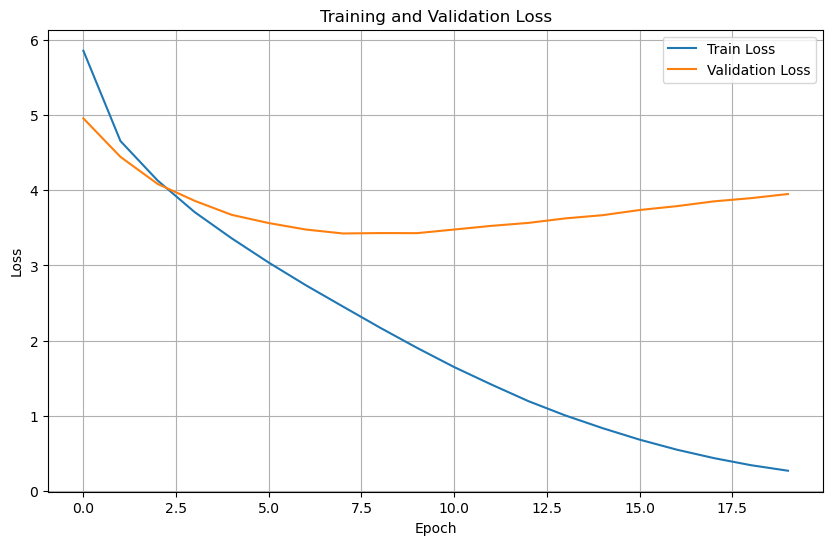

Test Loss: 4.9117


In [26]:
import math
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

# Load text data
def load_data(english_path, urdu_path):
    with open(english_path, 'r', encoding='utf-8') as f_en, open(urdu_path, 'r', encoding='utf-8') as f_ur:
        english_sentences = f_en.readlines()
        urdu_sentences = f_ur.readlines()
    return english_sentences, urdu_sentences

# Train tokenizers with special tokens
def train_tokenizer(data, vocab_size=8000):
    tokenizer = Tokenizer(models.BPE())
    special_tokens = ["<sos>", "<eos>", "<pad>"]
    trainer = trainers.BpeTrainer(vocab_size=vocab_size, min_frequency=2, special_tokens=special_tokens)
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    tokenizer.train_from_iterator(data, trainer)
    return tokenizer

# Tokenize and pad each sentence
def tokenize_sentence(tokenizer, sentence, max_length=50):
    tokens = ["<sos>"] + tokenizer.encode(sentence).tokens + ["<eos>"]
    token_ids = tokenizer.encode(" ".join(tokens)).ids
    token_ids = token_ids[:max_length] + [tokenizer.token_to_id("<pad>")] * (max_length - len(token_ids))
    return token_ids

# Tokenize and pad datasets
def tokenize_data(tokenizer, data, max_length=50):
    tokenized_data = [tokenize_sentence(tokenizer, sentence, max_length) for sentence in data]
    return torch.tensor(tokenized_data)

# Scaled Dot Product Attention
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.scale = 1 / math.sqrt(d_k)

    def forward(self, Q, K, V, mask=None):
        scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))
        attention_weights = torch.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.q_linear = nn.Linear(d_model, d_model)
        self.k_linear = nn.Linear(d_model, d_model)
        self.v_linear = nn.Linear(d_model, d_model)
        self.fc = nn.Linear(d_model, d_model)
        self.attention = ScaledDotProductAttention(self.d_k)

    def forward(self, Q, K, V, mask=None):
        batch_size = Q.size(0)
        Q = self.q_linear(Q).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.k_linear(K).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.v_linear(V).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        output, _ = self.attention(Q, K, V, mask)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
        return self.fc(output)

# Feedforward Layer
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.linear2(self.dropout(self.relu(self.linear1(x))))

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(1), :].unsqueeze(0).to(x.device)

# Encoder Layer
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, mask)))
        return self.norm2(x + self.dropout(self.ffn(x)))

# Decoder Layer
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_attn = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionWiseFeedForward(d_model, d_ff, dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, memory, src_mask=None, tgt_mask=None):
        x = self.norm1(x + self.dropout(self.self_attn(x, x, x, tgt_mask)))
        x = self.norm2(x + self.dropout(self.enc_attn(x, memory, memory, src_mask)))
        return self.norm3(x + self.dropout(self.ffn(x)))

# Transformer Model
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model=512, num_layers=6, num_heads=8, d_ff=2048, dropout=0.1):
        super().__init__()
        self.encoder = Encoder(src_vocab_size, d_model, num_layers, num_heads, d_ff, dropout)
        self.decoder = Decoder(tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout)

    def forward(self, src, tgt, src_mask=None, tgt_mask=None):
        memory = self.encoder(src, src_mask)
        output = self.decoder(tgt, memory, src_mask, tgt_mask)
        return output

# Train and Evaluate
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for src, tgt in loader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input, tgt_output = tgt[:, :-1], tgt[:, 1:]
        src_mask = (src != pad_id).unsqueeze(1).unsqueeze(2)
        tgt_mask = torch.tril(torch.ones((tgt_input.size(1), tgt_input.size(1)), device=device)).bool()

        optimizer.zero_grad()
        output = model(src, tgt_input, src_mask, tgt_mask)
        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)
        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input, tgt_output = tgt[:, :-1], tgt[:, 1:]
            src_mask = (src != pad_id).unsqueeze(1).unsqueeze(2)
            tgt_mask = torch.tril(torch.ones((tgt_input.size(1), tgt_input.size(1)), device=device)).bool()

            output = model(src, tgt_input, src_mask, tgt_mask)
            output = output.reshape(-1, output.size(-1))
            tgt_output = tgt_output.reshape(-1)
            loss = criterion(output, tgt_output)
            total_loss += loss.item()
    return total_loss / len(loader)

# Plotting function
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Training and Validation Loss")
    plt.grid()
    plt.show()

# Data preparation
train_english, train_urdu = load_data('umc005-corpus/quran/train.en', 'umc005-corpus/quran/train.ur')
test_english, test_urdu = load_data('umc005-corpus/quran/test.en', 'umc005-corpus/quran/test.ur')

english_tokenizer = train_tokenizer(train_english)
urdu_tokenizer = train_tokenizer(train_urdu)

train_english_encoded = tokenize_data(english_tokenizer, train_english)
train_urdu_encoded = tokenize_data(urdu_tokenizer, train_urdu)
test_english_encoded = tokenize_data(english_tokenizer, test_english)
test_urdu_encoded = tokenize_data(urdu_tokenizer, test_urdu)

train_dataset = TensorDataset(train_english_encoded, train_urdu_encoded)
test_dataset = TensorDataset(test_english_encoded, test_urdu_encoded)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Model, optimizer, loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
src_vocab_size = english_tokenizer.get_vocab_size()
tgt_vocab_size = urdu_tokenizer.get_vocab_size()

model = Transformer(src_vocab_size, tgt_vocab_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
pad_id = english_tokenizer.token_to_id("<pad>")
criterion = nn.CrossEntropyLoss(ignore_index=pad_id)

# Training loop
num_epochs = 20
train_losses = []
val_losses = []

print("Starting Training...")
start_time = time.time()

for epoch in range(num_epochs):
    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

end_time = time.time()
print(f"Training Completed in {(end_time - start_time):.2f} seconds")

# Plot losses
plot_losses(train_losses, val_losses)

# Test evaluation
test_loss = evaluate(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")


In [28]:
def calculate_bleu_and_rouge_with_logging(model, loader, urdu_tokenizer, log_samples=5):
    model.eval()
    bleu_scores = []
    rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    logged_samples = 0

    print("\nStarting BLEU and ROUGE evaluation...\n")
    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input = tgt[:, :-1]
            output = model(src, tgt_input)
            output = output.argmax(dim=-1)

            for i in range(output.size(0)):
                # Decode predictions and references
                pred_sentence = urdu_tokenizer.decode(
                    [token for token in output[i].cpu().tolist() if token not in ["<pad>", "<sos>", "<eos>"]]
                )
                tgt_sentence = urdu_tokenizer.decode(
                    [token for token in tgt[i, 1:].cpu().tolist() if token not in ["<pad>", "<sos>", "<eos>"]]
                )

                # BLEU score
                reference = [tgt_sentence.lower().split()]
                candidate = pred_sentence.lower().split()
                bleu_score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
                bleu_scores.append(bleu_score)

                # ROUGE scores
                rouge = rouge_scorer_instance.score(tgt_sentence.lower(), pred_sentence.lower())
                rouge_scores['rouge1'].append(rouge['rouge1'].fmeasure)
                rouge_scores['rouge2'].append(rouge['rouge2'].fmeasure)
                rouge_scores['rougeL'].append(rouge['rougeL'].fmeasure)

                # Log sample translations
                if logged_samples < log_samples:
                    logged_samples += 1
                    print(f"Sample {logged_samples}:")
                    print(f"  Predicted: {pred_sentence}")
                    print(f"  Reference: {tgt_sentence}")
                    print(f"  BLEU Score: {bleu_score:.4f}")
                    print(f"  ROUGE Scores: R1: {rouge['rouge1'].fmeasure:.4f}, "
                          f"R2: {rouge['rouge2'].fmeasure:.4f}, RL: {rouge['rougeL'].fmeasure:.4f}")
                    print("-" * 50)

    # Average scores
    avg_bleu = sum(bleu_scores) / len(bleu_scores) if bleu_scores else 0.0
    avg_rouge = {key: (sum(scores) / len(scores) if scores else 0.0) for key, scores in rouge_scores.items()}

    # Log summary
    print("\nEvaluation Summary:")
    print(f"  Average BLEU Score: {avg_bleu:.4f}")
    print("  Average ROUGE Scores:")
    print(f"    ROUGE-1 F1: {avg_rouge['rouge1']:.4f}")
    print(f"    ROUGE-2 F1: {avg_rouge['rouge2']:.4f}")
    print(f"    ROUGE-L F1: {avg_rouge['rougeL']:.4f}")

    # Additional stats
    print("\nAdditional Statistics:")
    print(f"  Total Sentences Evaluated: {len(bleu_scores)}")
    print(f"  Average Predicted Sentence Length: {sum(len(s.split()) for s in [urdu_tokenizer.decode([token for token in output[i].cpu().tolist() if token not in ['<pad>', '<sos>', '<eos>']]) for i in range(output.size(0))]) / len(bleu_scores):.2f}")
    print(f"  Average Reference Sentence Length: {sum(len(s.split()) for s in [urdu_tokenizer.decode([token for token in tgt[i, 1:].cpu().tolist() if token not in ['<pad>', '<sos>', '<eos>']]) for i in range(output.size(0))]) / len(bleu_scores):.2f}")

    return avg_bleu, avg_rouge


In [29]:
# Evaluate BLEU and ROUGE scores with logging
print("Evaluating BLEU and ROUGE scores with detailed logging...")
avg_bleu, avg_rouge = calculate_bleu_and_rouge_with_logging(model, test_loader, urdu_tokenizer)

print(f"Final Test BLEU Score: {avg_bleu:.4f}")
print(f"Final Test ROUGE Scores: {avg_rouge}")


Evaluating BLEU and ROUGE scores with detailed logging...

Starting BLEU and ROUGE evaluation...

Sample 1:
  Predicted: اس دار ہیں ہوں ہوں ہر ہوں کروں کروں کروں کروں کروں کروں ہوں ہوں ہوں کروں کروں ہوں ہوں ہوں ہوں ہوں ہوں کروں کروں ہوں ہوں ہوں کروں کروں کروں ہوں ہوں ہوں ہوں کروں کروں کروں کروں کروں کروں کروں کروں کروں کروں کروں ہوں ہوں
  Reference: قرابت دار یتیم کو ۔
  BLEU Score: 0.0037
  ROUGE Scores: R1: 0.0000, R2: 0.0000, RL: 0.0000
--------------------------------------------------
Sample 2:
  Predicted: یا رہ چیز چیز کرنے لئے ہوئے ہوں ہیں چاہئے زمین اپنی والا والا اپنی حد والا ، میرے رہ کروں ہوئے کروں کروں کروں کروں کروں کروں کروں کروں کروں کروں کروں کروں ہوئے ہوئے ہوئے ہوئے ہوئے ہوئے ہوئے ہوئے ہوئے میرے حکم حکم حکم حکم حکم
  Reference: یا شدید غ ربت کے مارے ہوئے محتاج کو جو محض خاک نشین اور بے گھر ہے ۔
  BLEU Score: 0.0045
  ROUGE Scores: R1: 0.0000, R2: 0.0000, RL: 0.0000
--------------------------------------------------
Sample 3:
  Predicted: جو جو اس بات جو سب یہ اس بندگی

# Lstm

Training started...
Epoch 1/20, Train Loss: 5.8235, Val Loss: 5.3095, Epoch Time: 5.51 seconds
Epoch 2/20, Train Loss: 4.8388, Val Loss: 4.9714, Epoch Time: 5.13 seconds
Epoch 3/20, Train Loss: 4.4246, Val Loss: 4.7731, Epoch Time: 4.95 seconds
Epoch 4/20, Train Loss: 4.1393, Val Loss: 4.6805, Epoch Time: 4.90 seconds
Epoch 5/20, Train Loss: 3.9107, Val Loss: 4.5803, Epoch Time: 4.93 seconds
Epoch 6/20, Train Loss: 3.7137, Val Loss: 4.5486, Epoch Time: 4.88 seconds
Epoch 7/20, Train Loss: 3.5349, Val Loss: 4.4949, Epoch Time: 4.87 seconds
Epoch 8/20, Train Loss: 3.3696, Val Loss: 4.4929, Epoch Time: 4.92 seconds
Epoch 9/20, Train Loss: 3.2152, Val Loss: 4.4854, Epoch Time: 4.88 seconds
Epoch 10/20, Train Loss: 3.0699, Val Loss: 4.5005, Epoch Time: 4.89 seconds
Epoch 11/20, Train Loss: 2.9269, Val Loss: 4.5244, Epoch Time: 4.90 seconds
Epoch 12/20, Train Loss: 2.7923, Val Loss: 4.5745, Epoch Time: 4.98 seconds
Epoch 13/20, Train Loss: 2.6610, Val Loss: 4.5709, Epoch Time: 4.81 seconds
E

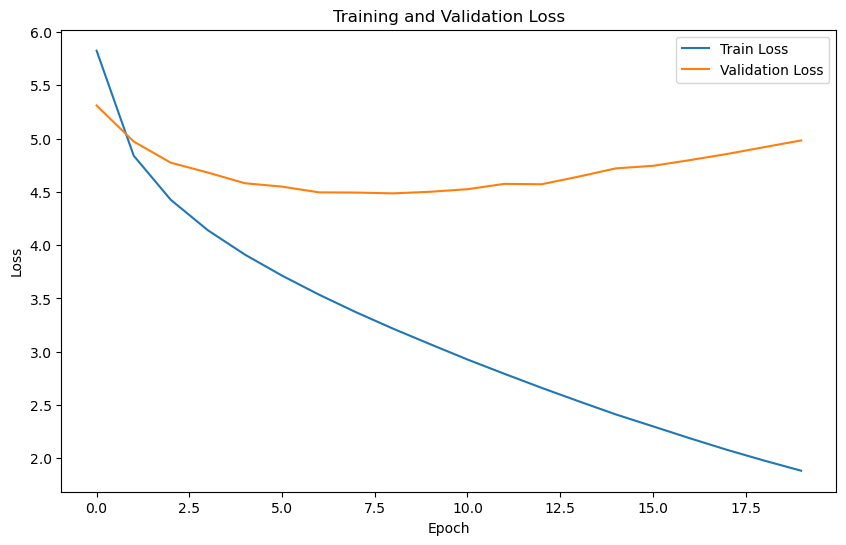

In [18]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from nltk.translate.bleu_score import sentence_bleu
import matplotlib.pyplot as plt
from tokenizers import Tokenizer, models, trainers, pre_tokenizers

# Load the text data
def load_data(english_path, urdu_path):
    with open(english_path, 'r', encoding='utf-8') as f_en, open(urdu_path, 'r', encoding='utf-8') as f_ur:
        english_sentences = f_en.readlines()
        urdu_sentences = f_ur.readlines()
    return english_sentences, urdu_sentences

# Tokenizer training
def train_tokenizer(data, vocab_size=8000):
    tokenizer = Tokenizer(models.BPE())
    special_tokens = ["<sos>", "<eos>", "<pad>"]
    trainer = trainers.BpeTrainer(vocab_size=vocab_size, min_frequency=2, special_tokens=special_tokens)
    tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()
    tokenizer.train_from_iterator(data, trainer)
    return tokenizer

# Tokenize and pad data
def tokenize_sentence(tokenizer, sentence, max_length=50):
    tokens = ["<sos>"] + tokenizer.encode(sentence).tokens + ["<eos>"]
    token_ids = tokenizer.encode(" ".join(tokens)).ids
    token_ids = token_ids[:max_length] + [tokenizer.token_to_id("<pad>")] * (max_length - len(token_ids))
    return token_ids

def tokenize_data(tokenizer, data, max_length=50):
    tokenized_data = [tokenize_sentence(tokenizer, sentence, max_length) for sentence in data]
    return torch.tensor(tokenized_data)

# Define Encoder
class LSTMEncoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.1):
        super(LSTMEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, (hidden, cell) = self.lstm(embedded)
        return hidden, cell

# Define Decoder
class LSTMDecoder(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers, dropout=0.1):
        super(LSTMDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, hidden, cell):
        embedded = self.dropout(self.embedding(tgt))
        outputs, (hidden, cell) = self.lstm(embedded, (hidden, cell))
        predictions = self.fc_out(outputs)
        return predictions, hidden, cell

# Define Seq2Seq Model
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, tgt):
        hidden, cell = self.encoder(src)
        outputs, _, _ = self.decoder(tgt, hidden, cell)
        return outputs

# Training step
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for src, tgt in loader:
        src, tgt = src.to(device), tgt.to(device)
        tgt_input, tgt_output = tgt[:, :-1], tgt[:, 1:]

        optimizer.zero_grad()
        output = model(src, tgt_input)
        output = output.reshape(-1, output.size(-1))
        tgt_output = tgt_output.reshape(-1)
        loss = criterion(output, tgt_output)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# Evaluation step
def evaluate(model, loader, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            tgt_input, tgt_output = tgt[:, :-1], tgt[:, 1:]
            output = model(src, tgt_input)
            output = output.reshape(-1, output.size(-1))
            tgt_output = tgt_output.reshape(-1)
            loss = criterion(output, tgt_output)
            total_loss += loss.item()
    return total_loss / len(loader)

# # BLEU score calculation
# def calculate_bleu(model, loader, urdu_tokenizer):
#     model.eval()
#     total_bleu = 0
#     with torch.no_grad():
#         for src, tgt in loader:
#             src, tgt = src.to(device), tgt.to(device)
#             tgt_input = tgt[:, :-1]
#             output = model(src, tgt_input)
#             output = output.argmax(dim=-1)

#             for i in range(output.size(0)):
#                 pred_sentence = urdu_tokenizer.decode(output[i].cpu().tolist())
#                 tgt_sentence = urdu_tokenizer.decode(tgt[i, 1:].cpu().tolist())
#                 total_bleu += sentence_bleu([tgt_sentence.split()], pred_sentence.split())
#     return total_bleu / len(loader)

# Plotting losses
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

# Load data
train_english, train_urdu = load_data('umc005-corpus/quran/train.en', 'umc005-corpus/quran/train.ur')
test_english, test_urdu = load_data('umc005-corpus/quran/test.en', 'umc005-corpus/quran/test.ur')

# Train and tokenize data
english_tokenizer = train_tokenizer(train_english)
urdu_tokenizer = train_tokenizer(train_urdu)

train_english_encoded = tokenize_data(english_tokenizer, train_english)
train_urdu_encoded = tokenize_data(urdu_tokenizer, train_urdu)
test_english_encoded = tokenize_data(english_tokenizer, test_english)
test_urdu_encoded = tokenize_data(urdu_tokenizer, test_urdu)

# Hyperparameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vocab_size_en = english_tokenizer.get_vocab_size()
vocab_size_ur = urdu_tokenizer.get_vocab_size()
embed_dim = 256
hidden_dim = 512
num_layers = 2
dropout = 0.1
batch_size = 32
num_epochs = 20
learning_rate = 1e-3

# Model, optimizer, loss
encoder = LSTMEncoder(vocab_size_en, embed_dim, hidden_dim, num_layers, dropout)
decoder = LSTMDecoder(vocab_size_ur, embed_dim, hidden_dim, num_layers, dropout)
model = Seq2Seq(encoder, decoder, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=english_tokenizer.token_to_id("<pad>"))

# DataLoaders
train_dataset = TensorDataset(train_english_encoded, train_urdu_encoded)
test_dataset = TensorDataset(test_english_encoded, test_urdu_encoded)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Training and validation
train_losses = []
val_losses = []
print("Training started...")
start_time = time.time()
for epoch in range(num_epochs):
    epoch_start_time = time.time()

    train_loss = train_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, test_loader, criterion)

    epoch_end_time = time.time()
    epoch_time = epoch_end_time - epoch_start_time

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Epoch Time: {epoch_time:.2f} seconds")

end_time = time.time()
total_time = end_time - start_time

print(f"Training completed in {total_time:.2f} seconds ({total_time / 60:.2f} minutes)")

# Plot losses
plot_losses(train_losses, val_losses)


In [19]:
# Evaluate BLEU and ROUGE scores with logging
print("Evaluating BLEU and ROUGE scores with detailed logging...")
avg_bleu, avg_rouge = calculate_bleu_and_rouge_with_logging(model, test_loader, urdu_tokenizer)

print(f"Final Test BLEU Score: {avg_bleu:.4f}")
print(f"Final Test ROUGE Scores: {avg_rouge}")


Evaluating BLEU and ROUGE scores with detailed logging...

Starting BLEU and ROUGE evaluation...

Sample 1:
  Predicted: اس کا تھ کے کھانا والی ہوگی ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ۔ ۔ ۔ ۔ ۔ کے کے کے کے ہو ہو ہو ہو ہو ہو ہو ہو ہو ہو ہو ہو ہو ہو ہو ہو ہو ہو کرلیں کرلیں کرلیں
  Reference: قرابت دار یتیم کو ۔
  BLEU Score: 0.0038
  ROUGE Scores: R1: 0.0000, R2: 0.0000, RL: 0.0000
--------------------------------------------------
Sample 2:
  Predicted: یا ان مقررہ طہارت کا سوا ن یا ہوں ان ان پہلے سے ہیں بدمستی خبر ہے ۔ ۔ ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے ہے
  Reference: یا شدید غ ربت کے مارے ہوئے محتاج کو جو محض خاک نشین اور بے گھر ہے ۔
  BLEU Score: 0.0090
  ROUGE Scores: R1: 0.0000, R2: 0.0000, RL: 0.0000
--------------------------------------------------
Sample 3:
  Predicted: اس اس اس بھی کہ اس بیوی و دانائی کروں کے اور شخص ہے کا کا سے ہے سکتا تم لے اور اور نیک دوسرے کے بھی کرتے امید میں کر راہ کی ہو ۔ نہ راہ ہے غمگین میں راہ ۔ ہیں ۔ 

In [49]:
pip install rouge_score

  Using cached rouge_score-0.1.2.tar.gz (17 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24970 sha256=f26a97e3c0afe16cf014f5d0e13040d6a1353b2334e6ac61010b33b4396c81f0
  Stored in directory: c:\users\abdul\appdata\local\pip\cache\wheels\1e\19\43\8a442dc83660ca25e163e1bd1f89919284ab0d0c1475475148
Successfully built rouge_score
Note: you may need to restart the kernel to use updated packages.


In [20]:
import torch
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer

# Load the test data
def load_test_data(english_path, urdu_path):
    with open(english_path, 'r', encoding='utf-8') as f_en, open(urdu_path, 'r', encoding='utf-8') as f_ur:
        english_sentences = f_en.readlines()
        urdu_sentences = f_ur.readlines()
    return english_sentences, urdu_sentences

# Load English and Urdu test sentences
test_english_data, test_urdu_data = load_test_data('umc005-corpus/quran/test.en', 'umc005-corpus/quran/test.ur')

# Translation function (same as before)
def translate_sentence(model, sentence, src_tokenizer, tgt_tokenizer, max_length=20, device='cpu'):
    model.eval()
    tokens = ["<sos>"] + src_tokenizer.encode(sentence).tokens + ["<eos>"]
    token_ids = src_tokenizer.encode(" ".join(tokens)).ids
    token_ids = token_ids[:max_length] + [src_tokenizer.token_to_id("<pad>")] * (max_length - len(token_ids))
    src_tensor = torch.tensor(token_ids).unsqueeze(0).to(device)
    src_mask = (src_tensor != src_tokenizer.token_to_id("<pad>")).unsqueeze(1).unsqueeze(2).to(device)
    tgt_tokens = ["<sos>"]
    tgt_ids = torch.tensor([tgt_tokenizer.token_to_id("<sos>")]).unsqueeze(0).to(device)

    for _ in range(max_length):
        tgt_mask = (tgt_ids != tgt_tokenizer.token_to_id("<pad>")).unsqueeze(1).unsqueeze(2)
        tgt_mask = tgt_mask & torch.tril(torch.ones((tgt_ids.size(1), tgt_ids.size(1)), device=device)).bool()
        
        with torch.no_grad():
            output = model(src_tensor, tgt_ids, src_mask, tgt_mask)
        
        next_token = output[:, -1, :].argmax(dim=-1).item()
        tgt_tokens.append(tgt_tokenizer.id_to_token(next_token))
        tgt_ids = torch.cat([tgt_ids, torch.tensor([[next_token]], device=device)], dim=1)

        if tgt_tokens[-1] == "<eos>":
            break

    return " ".join(tgt_tokens[1:-1])

# BLEU and ROUGE evaluation
def evaluate_model(model, test_english_data, test_urdu_data, src_tokenizer, tgt_tokenizer, device='cpu'):
    bleu_scores = []
    rouge_scorer_instance = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}

    for eng_sentence, ref_urdu_sentence in zip(test_english_data, test_urdu_data):
        # Generate translation
        pred_urdu_sentence = translate_sentence(model, eng_sentence.strip(), src_tokenizer, tgt_tokenizer, device=device)
        
        # BLEU score (using sentence-level BLEU with smoothing function)
        reference = [ref_urdu_sentence.strip().split()]
        candidate = pred_urdu_sentence.split()
        bleu_score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
        bleu_scores.append(bleu_score)

        # ROUGE scores
        rouge = rouge_scorer_instance.score(ref_urdu_sentence.strip(), pred_urdu_sentence)
        rouge_scores['rouge1'].append(rouge['rouge1'].fmeasure)
        rouge_scores['rouge2'].append(rouge['rouge2'].fmeasure)
        rouge_scores['rougeL'].append(rouge['rougeL'].fmeasure)

    # Average scores
    avg_bleu = sum(bleu_scores) / len(bleu_scores)
    avg_rouge = {key: sum(scores) / len(scores) for key, scores in rouge_scores.items()}

    return avg_bleu, avg_rouge

# Evaluate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

avg_bleu, avg_rouge = evaluate_model(model, test_english_data, test_urdu_data, english_tokenizer, urdu_tokenizer, device=device)
print(f"Average BLEU Score: {avg_bleu:.4f}")
print(f"Average ROUGE Scores: {avg_rouge}")


In [65]:
import torch
import pickle

# Assuming `model`, `english_tokenizer`, and `urdu_tokenizer` are already trained

# Save the model
torch.save(model.state_dict(), 'translation_model.pth')

# Save tokenizers using pickle
with open('english_tokenizer.pkl', 'wb') as f:
    pickle.dump(english_tokenizer, f)
with open('urdu_tokenizer.pkl', 'wb') as f:
    pickle.dump(urdu_tokenizer, f)


In [2]:
import torch

def translate_sentence(model, sentence, src_tokenizer, tgt_tokenizer, max_length=20, device='cpu'):
    """
    Translates an input sentence using the trained Transformer model.
    
    Args:
        model: Trained Transformer model.
        sentence: Input sentence in English (source language).
        src_tokenizer: Tokenizer for the source language (English).
        tgt_tokenizer: Tokenizer for the target language (Urdu).
        max_length: Maximum length of the translated sentence.
        device: Device to perform inference on.
        
    Returns:
        Translated sentence in Urdu.
    """
    model.eval()

    # Tokenize and prepare input sentence
    tokens = ["<sos>"] + src_tokenizer.encode(sentence).tokens + ["<eos>"]
    token_ids = src_tokenizer.encode(" ".join(tokens)).ids
    token_ids = token_ids[:max_length] + [src_tokenizer.token_to_id("<pad>")] * (max_length - len(token_ids))
    src_tensor = torch.tensor(token_ids).unsqueeze(0).to(device)  # Add batch dimension

    # Create source mask
    src_mask = (src_tensor != src_tokenizer.token_to_id("<pad>")).unsqueeze(1).unsqueeze(2).to(device)

    # Prepare target tensor with <sos> token
    tgt_tokens = ["<sos>"]
    tgt_ids = torch.tensor([tgt_tokenizer.token_to_id("<sos>")]).unsqueeze(0).to(device)

    # Iteratively predict tokens up to max_length
    for _ in range(max_length):
        tgt_mask = (tgt_ids != tgt_tokenizer.token_to_id("<pad>")).unsqueeze(1).unsqueeze(2)
        tgt_mask = tgt_mask & torch.tril(torch.ones((tgt_ids.size(1), tgt_ids.size(1)), device=device)).bool()
        
        with torch.no_grad():
            output = model(src_tensor, tgt_ids, src_mask, tgt_mask)
        
        # Select the token with the highest probability (argmax)
        next_token = output[:, -1, :].argmax(dim=-1).item()
        
        # Append to the target sequence
        tgt_tokens.append(tgt_tokenizer.id_to_token(next_token))
        tgt_ids = torch.cat([tgt_ids, torch.tensor([[next_token]], device=device)], dim=1)

        # Stop if end-of-sequence token is generated
        if tgt_tokens[-1] == "<eos>":
            break

    # Remove special tokens and join tokens to form the final translated sentence
    translated_sentence = " ".join(tgt_tokens[1:-1])  # Exclude <sos> and <eos>
    return translated_sentence

# Example usage:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Example sentence in English to translate
english_sentence = english_data[3]

# Translate the sentence
urdu_translation = translate_sentence(model, english_sentence, english_tokenizer, urdu_tokenizer, device=device)
print("Translated Sentence:", urdu_translation)


In [52]:
english_data[3]

'( O Allah ! ) You alone do we worship and to You alone we look for help .\n'

In [54]:
urdu_data[3]

'اے اللہ ! ہم تیری ہی عبادت کرتے ہیں اور ہم تجھ ہی سے مدد چاہتے ہیں ۔\n'

In [3]:
import tkinter as tk
from tkinter import ttk
from PIL import Image, ImageTk
import torch
import pickle
from torch import nn

# Define your Transformer model class here (assuming the model class is named Transformer)
# from your_model_definition_file import Transformer

# Load model and tokenizers
def load_model_and_tokenizers():
    # Load tokenizers
    with open('english_tokenizer.pkl', 'rb') as f:
        english_tokenizer = pickle.load(f)
    with open('urdu_tokenizer.pkl', 'rb') as f:
        urdu_tokenizer = pickle.load(f)

    # Get vocabulary sizes dynamically from tokenizers
    src_vocab_size = english_tokenizer.get_vocab_size()
    tgt_vocab_size = urdu_tokenizer.get_vocab_size()

    # Initialize model with dynamic vocabulary sizes
    d_model = 512
    num_layers = 6
    num_heads = 8
    d_ff = 2048
    dropout = 0.1

    model = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_layers, num_heads, d_ff, dropout)
    model.load_state_dict(torch.load('translation_model.pth', map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu")))
    model.eval()  # Set the model to evaluation mode

    return model, english_tokenizer, urdu_tokenizer

# Translation function
def translate_sentence(model, sentence, src_tokenizer, tgt_tokenizer, max_length=20, device='cpu'):
    model.eval()
    tokens = ["<sos>"] + src_tokenizer.encode(sentence).tokens + ["<eos>"]
    token_ids = src_tokenizer.encode(" ".join(tokens)).ids
    token_ids = token_ids[:max_length] + [src_tokenizer.token_to_id("<pad>")] * (max_length - len(token_ids))
    src_tensor = torch.tensor(token_ids).unsqueeze(0).to(device)
    src_mask = (src_tensor != src_tokenizer.token_to_id("<pad>")).unsqueeze(1).unsqueeze(2).to(device)
    tgt_tokens = ["<sos>"]
    tgt_ids = torch.tensor([tgt_tokenizer.token_to_id("<sos>")]).unsqueeze(0).to(device)

    for _ in range(max_length):
        tgt_mask = (tgt_ids != tgt_tokenizer.token_to_id("<pad>")).unsqueeze(1).unsqueeze(2).to(device)
        tgt_mask = tgt_mask & torch.tril(torch.ones((tgt_ids.size(1), tgt_ids.size(1)), device=device)).bool()
        
        with torch.no_grad():
            output = model(src_tensor, tgt_ids, src_mask, tgt_mask)
        
        next_token = output[:, -1, :].argmax(dim=-1).item()
        tgt_tokens.append(tgt_tokenizer.id_to_token(next_token))
        tgt_ids = torch.cat([tgt_ids, torch.tensor([[next_token]], device=device)], dim=1)

        if tgt_tokens[-1] == "<eos>":
            break

    return " ".join(tgt_tokens[1:-1])

# Tkinter app class
class TranslationApp:
    def __init__(self, root, model, english_tokenizer, urdu_tokenizer):
        self.root = root
        self.model = model
        self.english_tokenizer = english_tokenizer
        self.urdu_tokenizer = urdu_tokenizer
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model.to(self.device)  # Move the model to the selected device

        # Configure window
        self.root.title("English to Urdu Translator")
        self.root.geometry("600x400")
        self.root.configure(bg="#F3F4F6")

        # Background Image
        self.background_image = Image.open("h.jpg").resize((600, 400), Image.LANCZOS)
        self.background_photo = ImageTk.PhotoImage(self.background_image)
        background_label = tk.Label(root, image=self.background_photo)
        background_label.place(relwidth=1, relheight=1)

        # Title Label
        title_label = tk.Label(root, text="English to Urdu Translator", font=("Arial", 20, "bold"), fg="white", bg="gray")
        title_label.place(relx=0.5, rely=0.1, anchor="center")

        # Input Box
        self.input_text = tk.StringVar()
        input_frame = tk.Frame(root, bg="gray", bd=2)
        input_frame.place(relx=0.5, rely=0.3, anchor="center", width=500, height=40)
        self.input_entry = tk.Entry(input_frame, textvariable=self.input_text, font=("Arial", 14), bd=0, relief="flat", width=45)
        self.input_entry.pack(fill="both", padx=5, pady=5)

        # Translate Button
        self.translate_button = tk.Button(root, text="Translate", command=self.translate_text, font=("Arial", 12, "bold"),
                                          bg="#3498DB", fg="white", relief="flat", cursor="hand2")
        self.translate_button.place(relx=0.5, rely=0.45, anchor="center", width=100, height=30)

        # Output Box
        output_frame = tk.Frame(root, bg="gray", bd=2)
        output_frame.place(relx=0.5, rely=0.6, anchor="center", width=500, height=40)
        self.output_text = tk.Label(output_frame, text="", font=("Arial", 14), bg="#FFFFFF", wraplength=480, justify="left")
        self.output_text.pack(fill="both", padx=5, pady=5)

    def translate_text(self):
        # Get the input text and translate it
        english_text = self.input_text.get()
        if english_text:
            translated_text = translate_sentence(self.model, english_text, self.english_tokenizer, self.urdu_tokenizer, device=self.device)
            self.output_text.config(text=translated_text)
        else:
            self.output_text.config(text="Please enter text to translate.")

# Run the app
if __name__ == "__main__":
    # Load model and tokenizers with dynamic vocabulary sizes
    model, english_tokenizer, urdu_tokenizer = load_model_and_tokenizers()

    # Initialize Tkinter root and TranslationApp
    root = tk.Tk()
    app = TranslationApp(root, model, english_tokenizer, urdu_tokenizer)
    root.mainloop()


NameError: name 'Transformer' is not defined